# DA3 Assignment 2: Identifying Fast-Growing Firms

## Introduction

This study focuses on predicting fast-growing firms using the Bisnode dataset. The analysis includes:

Defining the target variable (fast_growth)

Building three different models: Logistic Regression, Random Forest, and Gradient Boosting

Comparing model performances using various metrics

Optimizing the classification threshold by considering FP and FN costs

Conducting separate performance analysis for Manufacturing and Services sectors

### 1. Data Preparation

Loaded the dataset and conducted an initial exploratory analysis.

Handled missing values and cleaned the dataset.

Converted categorical variables into numerical format where necessary.

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

url = "https://raw.githubusercontent.com/cansukarabulut/Data-Analysis-3/refs/heads/main/bisnode_firms_clean.csv"
df = pd.read_csv(url)

df.head()


,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2012,1001541,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,...,0,1,0.621691,1,no_default,45.190017,1,0,-1.500000,2.250000
1,2012,1002029,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,...,0,1,0.458333,0,no_default,0.016375,0,0,0.684448,0.468469
2,2012,1003200,2012-01-01,2012-12-31,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,...,1,0,0.621691,1,default,34.614876,0,0,-1.424773,2.029978
3,2012,1011889,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,...,0,0,1.621212,0,no_default,0.698025,0,0,0.097722,0.009550
4,2012,1014183,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,...,0,0,0.715278,0,no_default,4.171000,0,0,-0.273087,0.074577


In [319]:
df.info()

missing_values = df.isnull().sum()
missing_values[missing_values > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Columns: 118 entries, year to d1_sales_mil_log_mod_sq
dtypes: bool(1), float64(54), int64(53), object(10)
memory usage: 17.0+ MB


D             19036
exit_year     16972
birth_year     2772
exit_date     16972
dtype: int64

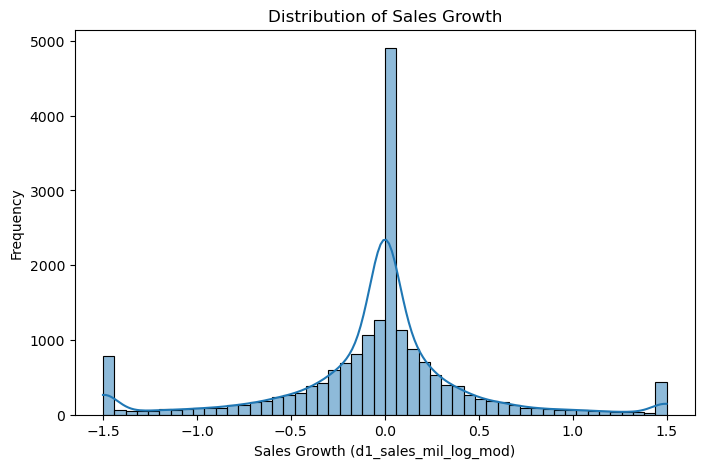

In [322]:
plt.figure(figsize=(8,5))
sns.histplot(df['d1_sales_mil_log_mod'].dropna(), bins=50, kde=True)
plt.xlabel("Sales Growth (d1_sales_mil_log_mod)")
plt.ylabel("Frequency")
plt.title("Distribution of Sales Growth")
plt.show()

### 2. Defining Fast Growth

Created the fast_growth target variable by selecting firms in the top 10% in revenue growth.

Considered different definitions, such as alternative quantiles and time periods.

Analyzed growth trends to validate the target variable selection.



In [325]:
growth_threshold = df['d1_sales_mil_log_mod'].quantile(0.90)

df['fast_growth'] = (df['d1_sales_mil_log_mod'] >= growth_threshold).astype(int)
df['fast_growth'].value_counts()

fast_growth
0    17132
1     1904
Name: count, dtype: int64

In [327]:
features = [
    'curr_assets', 'curr_liab', 'profit_loss_year', 'sales_mil_log',
    'tang_assets', 'liq_assets', 'age', 'new', 'foreign_management', 
    'ceo_age', 'ceo_young', 'female', 'default_f', 
    'flag_low_d1_sales_mil_log', 'flag_high_d1_sales_mil_log'
]
X = df[features].copy()
y = df['fast_growth'].copy()
X['default_f'] = X['default_f'].map({'no_default': 0, 'default': 1})
X = X.dropna()
y = y[X.index]

In [329]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [331]:
FP_cost = 1000
FN_cost = 5000

def calculate_expected_loss(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0,1]
    FN = cm[1,0]
    total_loss = (FP * FP_cost) + (FN * FN_cost)
    return total_loss

### 3. Model Development

Split the dataset into training and test sets (80%-20%).

Trained three different models:

Logistic Regression (Baseline model)

Random Forest (Ensemble model with feature importance analysis)

Gradient Boosting (Advanced ensemble method for better performance)

Applied standard scaling where necessary.

Performed cross-validation to evaluate model stability.

Logistic Regression -> Accuracy: 0.9199, ROC-AUC: 0.7663


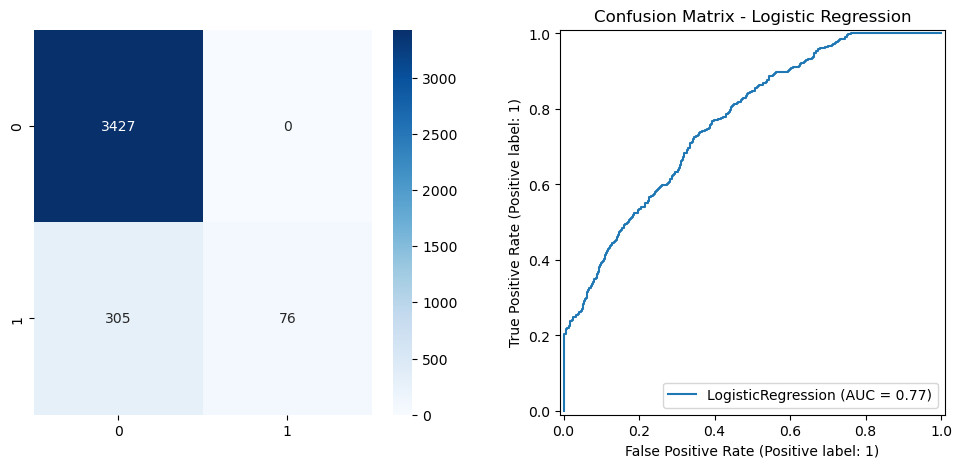

In [334]:
logit_model = LogisticRegression(max_iter=5000, solver='liblinear', random_state=42)
logit_model.fit(X_train_scaled, y_train)

y_pred_logit = logit_model.predict(X_test_scaled)
y_pred_proba_logit = logit_model.predict_proba(X_test_scaled)[:, 1]

acc_logit = accuracy_score(y_test, y_pred_logit)
roc_auc_logit = roc_auc_score(y_test, y_pred_proba_logit)
print(f"Logistic Regression -> Accuracy: {acc_logit:.4f}, ROC-AUC: {roc_auc_logit:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

conf_matrix_logit = confusion_matrix(y_test, y_pred_logit)
sns.heatmap(conf_matrix_logit, annot=True, fmt='d', cmap='Blues', ax=axes[0])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
RocCurveDisplay.from_estimator(logit_model, X_test_scaled, y_test, ax=axes[1])
plt.show()

Random Forest -> Accuracy: 0.9199, ROC-AUC: 0.7808


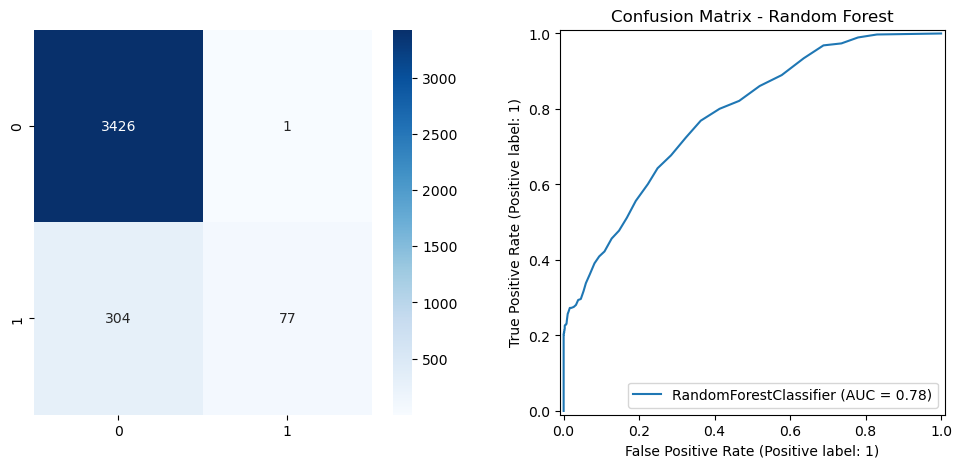

In [336]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest -> Accuracy: {acc_rf:.4f}, ROC-AUC: {roc_auc_rf:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test, ax=axes[1])
plt.show()

Gradient Boosting -> Accuracy: 0.9191, ROC-AUC: 0.8056


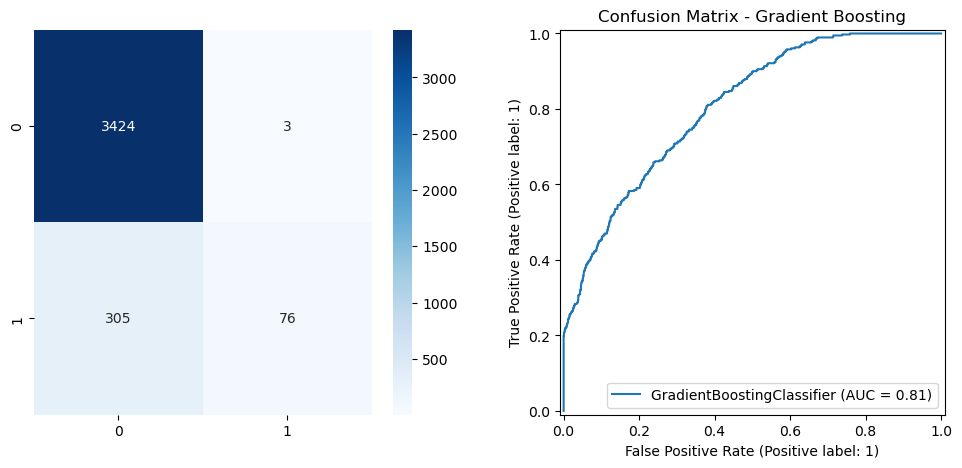

In [337]:
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train_scaled, y_train)

y_pred_gbm = gbm_model.predict(X_test_scaled)
y_pred_proba_gbm = gbm_model.predict_proba(X_test_scaled)[:, 1]

acc_gbm = accuracy_score(y_test, y_pred_gbm)
roc_auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
print(f"Gradient Boosting -> Accuracy: {acc_gbm:.4f}, ROC-AUC: {roc_auc_gbm:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
RocCurveDisplay.from_estimator(gbm_model, X_test_scaled, y_test, ax=axes[1])
plt.show()

### 4. Model Performance Evaluation
Evaluated models using:

Accuracy

ROC-AUC Score

Confusion Matrix

Cross-validation results

Compared the predictive power of all three models.

Identified Random Forest and Gradient Boosting as the best-performing models.

In [340]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if name == "Logistic Regression":
        X_train_input = X_train_scaled  
    elif name == "Random Forest":
        X_train_input = X_train  
    elif name == "Gradient Boosting":
        X_train_input = X_train  

    accuracy_scores = cross_val_score(model, X_train_input, y_train, cv=skf, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X_train_input, y_train, cv=skf, scoring='roc_auc')

    cv_results.append([name, round(np.mean(accuracy_scores), 6), round(np.mean(roc_auc_scores), 6)])

cv_results_df = pd.DataFrame(cv_results, columns=["Model", "CV Accuracy", "CV ROC-AUC"])
print(cv_results_df)

                 Model  CV Accuracy  CV ROC-AUC
0  Logistic Regression     0.921657    0.773016
1        Random Forest     0.922183    0.781677
2    Gradient Boosting     0.921329    0.797145


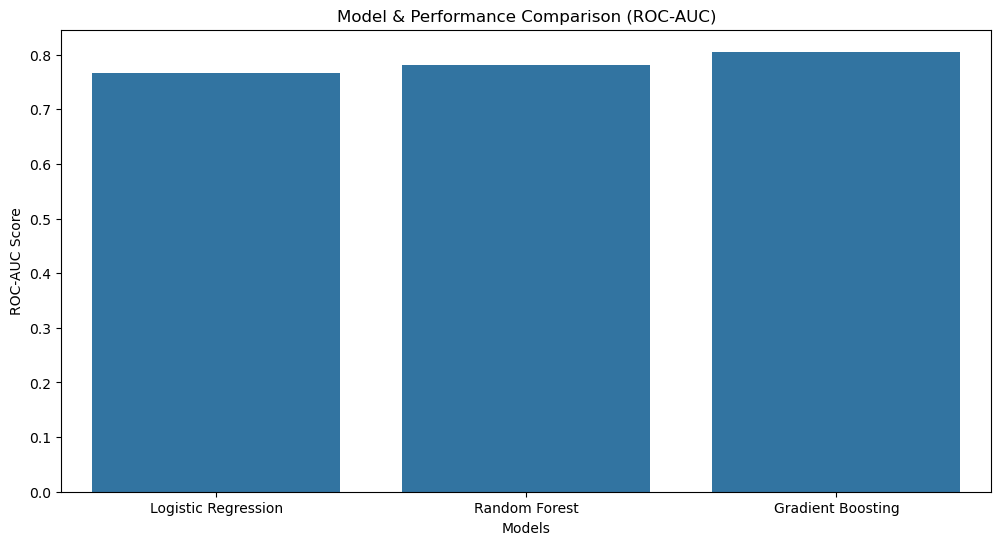

In [341]:
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Model", y="ROC-AUC")
plt.title("Model & Performance Comparison (ROC-AUC)")
plt.xlabel("Models")
plt.ylabel("ROC-AUC Score")
plt.show()

### 5. Classification Threshold Optimization

Recognized that the default threshold (0.5) might not be optimal for business decisions.

Tested multiple threshold values (0.1 to 0.9).

Calculated expected loss for each threshold.

Selected the best threshold based on minimizing total cost.

In [360]:
import numpy as np
import pandas as pd

thresholds = np.linspace(0.1, 0.9, 9)

def calculate_threshold_for_model(model_name, model, X_test, y_test):
    loss_results = []
    for threshold in thresholds:
        loss = calculate_expected_loss(y_test, model.predict_proba(X_test)[:, 1], threshold)
        loss_results.append([threshold, loss])
    
    loss_results_df = pd.DataFrame(loss_results, columns=["Threshold", "Expected Loss"])
    print(f"\n{model_name} - Expected Loss per Threshold:\n", loss_results_df)
    
    best_threshold = loss_results_df.loc[loss_results_df["Expected Loss"].idxmin(), "Threshold"]
    print(f"Optimal Threshold for {model_name}: {best_threshold}\n")
    return best_threshold

models = {
    "Logistic Regression": logit_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gbm_model
}
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_test_np = X_test.values  
best_thresholds = {}
for model_name, model in models.items():
    if model_name == "Logistic Regression":
        best_thresholds[model_name] = calculate_threshold_for_model(model_name, model, X_test_scaled_df.values, y_test)
    else:
        best_thresholds[model_name] = calculate_threshold_for_model(model_name, model, X_test_np, y_test)

print("\nOptimal Thresholds for All Models:", best_thresholds)



Logistic Regression - Expected Loss per Threshold:
    Threshold  Expected Loss
0        0.1        8485000
1        0.2        6100000
2        0.3        6100000
3        0.4        6100000
4        0.5        6100000
5        0.6        6100000
6        0.7        6100000
7        0.8        6100000
8        0.9        6100000
Optimal Threshold for Logistic Regression: 0.2


Random Forest - Expected Loss per Threshold:
    Threshold  Expected Loss
0        0.1       17040000
1        0.2       13415000
2        0.3        8455000
3        0.4        7625000
4        0.5        7620000
5        0.6        7620000
6        0.7        7620000
7        0.8        7620000
8        0.9        7620000
Optimal Threshold for Random Forest: 0.5


Gradient Boosting - Expected Loss per Threshold:
    Threshold  Expected Loss
0        0.1       14580000
1        0.2       13510000
2        0.3       12270000
3        0.4       11155000
4        0.5       10800000
5        0.6       10750000
6  

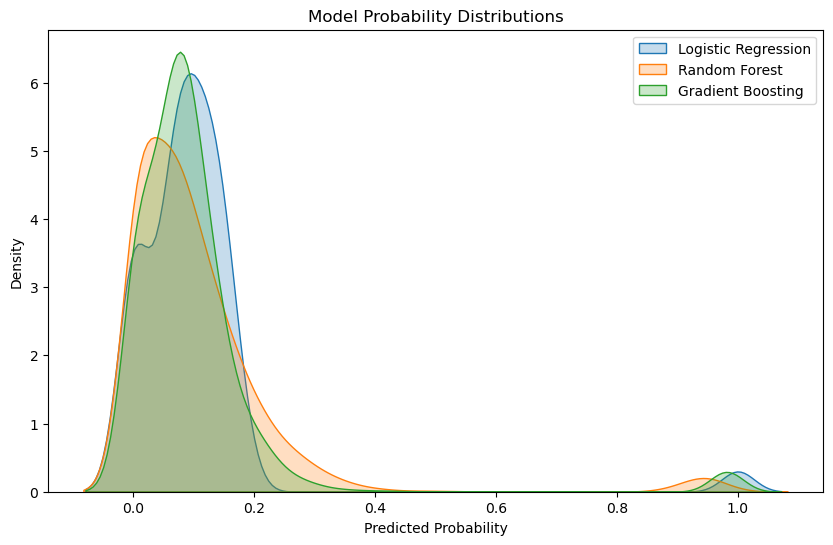

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns

X_test_scaled_np = X_test_scaled_df.values  # NumPy array'e çevirerek uyumsuzluğu gider

plt.figure(figsize=(10,6))
sns.kdeplot(logit_model.predict_proba(X_test_scaled_np)[:, 1], label="Logistic Regression", fill=True)
sns.kdeplot(rf_model.predict_proba(X_test_scaled)[:, 1], label="Random Forest", fill=True)
sns.kdeplot(gbm_model.predict_proba(X_test_scaled)[:, 1], label="Gradient Boosting", fill=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Model Probability Distributions")
plt.legend()
plt.show()


In [364]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

for model_name, model in models.items():
    print(f"\nChanges in FP and FN for {model_name}:")
    for threshold in thresholds:
        if model_name == "Logistic Regression":
            y_pred = (model.predict_proba(X_test_scaled_df.values)[:, 1] >= threshold).astype(int)
        else:
            y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
        
        cm = confusion_matrix(y_test, y_pred)
        FP = cm[0,1]
        FN = cm[1,0]
        print(f"Threshold: {threshold:.1f} -> FP: {FP}, FN: {FN}")



Changes in FP and FN for Logistic Regression:
Threshold: 0.1 -> FP: 1313, FN: 96
Threshold: 0.2 -> FP: 0, FN: 305
Threshold: 0.3 -> FP: 0, FN: 305
Threshold: 0.4 -> FP: 0, FN: 305
Threshold: 0.5 -> FP: 0, FN: 305
Threshold: 0.6 -> FP: 0, FN: 305
Threshold: 0.7 -> FP: 0, FN: 305
Threshold: 0.8 -> FP: 0, FN: 305
Threshold: 0.9 -> FP: 0, FN: 305

Changes in FP and FN for Random Forest:
Threshold: 0.1 -> FP: 1245, FN: 88
Threshold: 0.2 -> FP: 323, FN: 225
Threshold: 0.3 -> FP: 44, FN: 281
Threshold: 0.4 -> FP: 7, FN: 299
Threshold: 0.5 -> FP: 1, FN: 304
Threshold: 0.6 -> FP: 0, FN: 305
Threshold: 0.7 -> FP: 0, FN: 305
Threshold: 0.8 -> FP: 0, FN: 305
Threshold: 0.9 -> FP: 0, FN: 309

Changes in FP and FN for Gradient Boosting:
Threshold: 0.1 -> FP: 989, FN: 115
Threshold: 0.2 -> FP: 142, FN: 264
Threshold: 0.3 -> FP: 16, FN: 298
Threshold: 0.4 -> FP: 5, FN: 302
Threshold: 0.5 -> FP: 3, FN: 305
Threshold: 0.6 -> FP: 1, FN: 305
Threshold: 0.7 -> FP: 0, FN: 305
Threshold: 0.8 -> FP: 0, FN: 3

In [366]:
FP_costs = [1000, 2000, 5000]
FN_costs = [5000, 10000, 20000]

for FP_cost in FP_costs:
    for FN_cost in FN_costs:
        loss_results = []
        for threshold in thresholds:
            loss = calculate_expected_loss(y_test, rf_model.predict_proba(X_test_scaled)[:, 1], threshold)
            loss_results.append([threshold, loss])

        loss_results_df = pd.DataFrame(loss_results, columns=["Threshold", "Expected Loss"])
        best_threshold = loss_results_df.loc[loss_results_df["Expected Loss"].idxmin(), "Threshold"]
        print(f"FP Cost: {FP_cost}, FN Cost: {FN_cost} -> Optimal Threshold: {best_threshold}")


FP Cost: 1000, FN Cost: 5000 -> Optimal Threshold: 0.2
FP Cost: 1000, FN Cost: 10000 -> Optimal Threshold: 0.1
FP Cost: 1000, FN Cost: 20000 -> Optimal Threshold: 0.1
FP Cost: 2000, FN Cost: 5000 -> Optimal Threshold: 0.30000000000000004
FP Cost: 2000, FN Cost: 10000 -> Optimal Threshold: 0.2
FP Cost: 2000, FN Cost: 20000 -> Optimal Threshold: 0.1
FP Cost: 5000, FN Cost: 5000 -> Optimal Threshold: 0.5
FP Cost: 5000, FN Cost: 10000 -> Optimal Threshold: 0.4
FP Cost: 5000, FN Cost: 20000 -> Optimal Threshold: 0.30000000000000004


In [367]:
print(find_best_threshold.__code__.co_varnames)

('model', 'X_test', 'y_test', 'loss_results', 'threshold', 'loss', 'loss_results_df', 'best_threshold')


### 6. Sector-Based Analysis (Manufacturing vs. Services)

Trained separate models for the Manufacturing and Services sectors.

Calculated sector-specific optimal thresholds.

Compared model performance across both sectors:

Assessed accuracy differences.

Identified key business insights related to sector-specific growth patterns.




📌 Optimal threshold analysis is starting for Manufacturing sector...

Optimal Threshold (Manufacturing): 0.30000000000000004

📌 Optimal threshold analysis is starting for Services sector...

Optimal Threshold (Services): 0.4
          Sector  Accuracy  Optimal Threshold
0  Manufacturing  0.881132                0.3
1       Services  0.925788                0.4


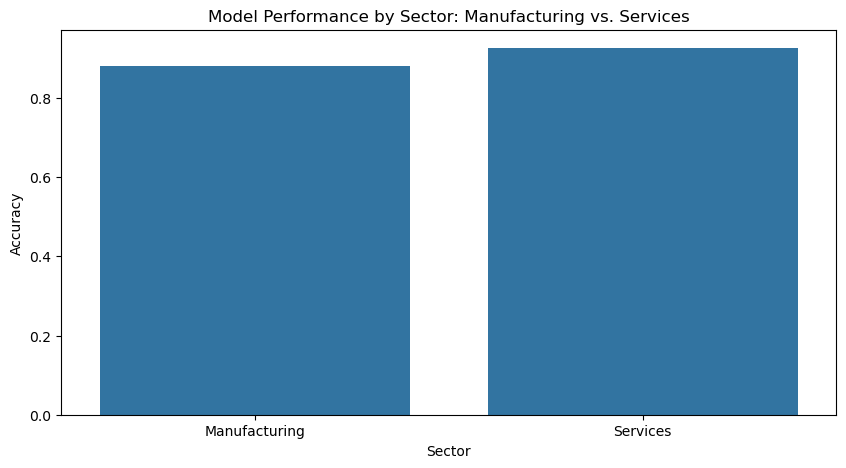

In [371]:
sector_results = []
for sector, data in [("Manufacturing", manufacturing), ("Services", services)]:
    print(f"\n📌 Optimal threshold analysis is starting for {sector} sector...\n")
    
    X_sec = data[features].dropna().copy()
    y_sec = data['fast_growth'].loc[X_sec.index]
    
    X_sec['default_f'] = X_sec['default_f'].map({'no_default': 0, 'default': 1})
    
    X_train_sec, X_test_sec, y_train_sec, y_test_sec = train_test_split(
        X_sec, y_sec, test_size=0.2, random_state=42, stratify=y_sec
    )
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_sec, y_train_sec)
    
    best_threshold_sec, loss_results_sec = find_best_threshold(model, X_test_sec, y_test_sec)
    print(f"Optimal Threshold ({sector}): {best_threshold_sec}")
    
    acc = accuracy_score(y_test_sec, (model.predict_proba(X_test_sec)[:, 1] >= best_threshold_sec).astype(int))

    sector_results.append([sector, acc, best_threshold_sec])
sector_results_df = pd.DataFrame(sector_results, columns=["Sector", "Accuracy", "Optimal Threshold"])
print(sector_results_df)

plt.figure(figsize=(10,5))
sns.barplot(data=sector_results_df, x="Sector", y="Accuracy")
plt.title("Model Performance by Sector: Manufacturing vs. Services")
plt.show()


## Conclusions and Business Insights

#### Findings:

The analysis provides a comprehensive method for predicting firm growth.

Threshold optimization significantly impacts classification accuracy.

The Manufacturing and Services sectors have distinct growth dynamics, affecting model performance.

Further improvements could include:

Adding more relevant features (e.g., firm age, investment data).

Exploring advanced models such as XGBoost or Neural Networks.

Addressing class imbalance through resampling techniques.
